In [ ]:
#Installing Selinium

!apt update
!apt install chromium-chromedriver
!pip install selenium
!pip install selenium-stealth
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb && apt install ./google-chrome-stable_current_amd64.deb

In [90]:
#Library and stealth config:
from time import sleep
from selenium_stealth import stealth
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

options = webdriver.ChromeOptions()
#run Selenium in headless mode
options.add_argument('--headless')
options.add_argument('--no-sandbox')
#overcome limited resource problems
options.add_argument('--disable-dev-shm-usage')
options.add_argument("lang=en")
#open Browser in maximized mode
options.add_argument("start-maximized")
#disable infobars
options.add_argument("disable-infobars")
#disable extension
options.add_argument("--disable-extensions")
options.add_argument("--incognito")
options.add_argument("--disable-blink-features=AutomationControlled")

driver = webdriver.Chrome(options=options)

stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )

In [91]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup as bs
import re
from data_formation import FlightInformation
from data_detail import Source




---

**Testing of webscrapping**


---



In [ ]:
def giveMeData(url, driver):
  driver.get(url)
  sleep(10)
  button = driver.find_element(By.XPATH, "//div[@class='ULvh']")
  count = len(driver.find_elements(By.XPATH, "//div/div[@class='nrc6']"))
  wait = WebDriverWait(driver, 20)

  while count <= 50:
    try:
      wait.until(EC.presence_of_element_located((By.XPATH, "//div[@class='ULvh']")) or EC.presence_of_element_located((By.XPATH, "//div[@role='button']"))).click()
    except Exception as e:
      print("error: ", e)
    count = len(driver.find_elements(By.XPATH, "//div/div[@class='nrc6']"))

    if count > 50:
      break

  wait.until(EC.element_to_be_clickable((By.XPATH, "//div/div[@class='nrc6-content-section']")))
  btnDetail = driver.find_elements(By.XPATH, "//div/div[@class='nrc6-content-section']")

  for btn in btnDetail:
    try:
      btn.click()
    except Exception as e:
      if (e == 'ElementClickInterceptedException'):
        continue

  resource = BeautifulSoup(driver.page_source, 'html.parser')
  # print(resource)

  flights = resource.find_all("div", class_="nrc6")

  for flight in flights:
    timeNAirline = flight.find("div", class_="VY2U")
    numberStop = flight.find("div", class_="JWEO")
    duration = flight.find("div", class_="xdW8")
    layovers = flight.find("div", class_="o-C7")
    if layovers == None:
      continue
    layover = layovers.find("span", class_="c62AT-duration c62AT-mod-variant-default")

    price = flight.find("div", class_="f8F1")
    if layover == None:
      continue
    # print("layover: ", layover.text)
    print(timeNAirline.text[:17] + " " + timeNAirline.text[19:] + " " + numberStop.text[:6] + " " + duration.text[:6] + " " + layover.text  + " " + price.text[1:])

giveMeData('https://www.kayak.com/flights/HEL-NRT/2023-11-20/2023-11-23?sort=bestflight_a', driver)





---


**Scrapping Momondo Website**


---



---



In [ ]:


def initialize_driver(url):
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument("lang=en")
    options.add_argument("start-maximized")
    options.add_argument("disable-infobars")
    options.add_argument("--disable-extensions")
    options.add_argument("--incognito")
    options.add_argument("--disable-blink-features=AutomationControlled")

    driver = webdriver.Chrome(options=options)

    stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
    driver.get(
        url,
    )
    for _ in range(10):
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located(
                (By.CSS_SELECTOR, "div.resultsPaginator div.show-more-button")
            )
        )
        press_button_pagination(driver=driver)
    webpage = driver.page_source
    return driver, webpage

class Momondo(Source):
    def __init__(self):
        url = "https://www.momondo.com/flight-search/HEL-NYC/2023-11-18/2023-12-04?sort=bestflight_a"
        self.driver, self.website = initialize_driver(url)

    def scrape(self):
        print("Scraping Website")
        webpage = self.website
        soup = bs(webpage, "html.parser")
        html = soup.prettify()
        flight_list = soup.find_all(class_="nrc6")
        flights = find_flights(flight_list=flight_list)
        quit_driver(self.driver)
        return flights

def press_button_pagination(driver):
    try:
        more_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "div.resultsPaginator div.show-more-button")
            )
        )
        more_button.click()
        WebDriverWait(driver, 30)
    except Exception as e:
        print(str(e))



def find_text_elements(list_element, selector, element="span"):
    return list_element.find(element, selector).text


def return_transit_details(transits):
    flight = transits[0]
    flight_time = flight.find("div", "vmXl vmXl-mod-variant-large")
    flight_time_spans = flight_time.find_all("span")
    departure_time, arrival_time = flight_time_spans[0].text, flight_time_spans[2].text
    airport_names = flight.find_all("span", "EFvI-ap-info")
    depart_location, arrival_location = airport_names[0].text, airport_names[1].text
    stop_div = flight.find("div", "JWEO")
    stop_text = stop_div.find("span", "JWEO-stops-text").text
    airport_name = None
    transit_location = None
    layover_time = None
    multiple_stops = stop_text != "direct"
    # print(multiple_stops)
    flight_duration = flight.find_all("div", "vmXl vmXl-mod-variant-default")[1].text
    if multiple_stops:
        stop = stop_div.find("div", "c_cgF c_cgF-mod-variant-default")
        span_element = stop.find_all("span")
        pattern = r"<b>(.*?)</b>"
        # print(span_element)
        if len(span_element) > 0:
            airport_name = re.findall(pattern, span_element[1]["title"][0])
            transit_location = span_element[1].text
            layover_time = span_element[1]["title"].split(" layover,")[0]
    return (
        depart_location,
        arrival_location,
        multiple_stops,
        transit_location,
        layover_time,
        None,
        departure_time,
        arrival_time,
        flight_duration,
    )


def find_flights(flight_list):
    list_structured_flight = list()
    for flights in flight_list:
        transit_flights = flights.find_all("li", "hJSA-item")
        flight = return_transit_details(transits=transit_flights)
        airlines_div = flights.find_all("div", "J0g6-labels-grp")
        price = flights.find("div", "f8F1-price-text").text
        airline_name = None
        if len(airlines_div) != 0:
            airlines = airlines_div[0].find("div", "J0g6-operator-text")
            if airlines:
                airline_name = airlines.text.split("Operated by")[1]
                print(airline_name)
        flight_info = FlightInformation(
            airline_names=airline_name,
            departure_time=flight[6],
            arrival_time=flight[7],
            departure_location=flight[0],
            arrival_destination=flight[1],
            flight_duration=flight[-1],
            direct_flight=flight[2],
            layover_time=flight[4],
            transit_location=flight[3],
            transit_airport=flight[5],
            flight_price=price,
            source=None,
            scraped_website="Momondo",
        )
        list_structured_flight.append(flight_info)
    return list_structured_flight

def quit_driver(driver):
    driver.quit()

if __name__ == "__main__":
    m = Momondo()
    m.save_file()


In [82]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup as bs
import re
from data_formation import FlightInformation
from data_detail import Source


def press_button_pagination(driver):
    try:
        more_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "div.resultsPaginator div.show-more-button")
            )
        )
        more_button.click()
        WebDriverWait(driver, 30)
    except Exception as e:
        print(str(e))


def initialize_driver(url):
    options = webdriver.ChromeOptions()
#run Selenium in headless mode
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
#overcome limited resource problems
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument("lang=en")
#open Browser in maximized mode
    options.add_argument("start-maximized")
#disable infobars
    options.add_argument("disable-infobars")
#disable extension
    options.add_argument("--disable-extensions")
    options.add_argument("--incognito")
    options.add_argument("--disable-blink-features=AutomationControlled")

    driver = webdriver.Chrome(options=options)

    stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
    driver.get(
        url,
    )
    for _ in range(10):
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located(
                (By.CSS_SELECTOR, "div.resultsPaginator div.show-more-button")
            )
        )
        press_button_pagination(driver=driver)
    webpage = driver.page_source
    return driver, webpage


def quit_driver(driver):
    driver.quit()


def find_text_elements(list_element, selector, element="span"):
    return list_element.find(element, selector).text


def return_transit_details(transits):
    flight = transits[0]
    flight_time = flight.find("div", "vmXl vmXl-mod-variant-large")
    flight_time_spans = flight_time.find_all("span")
    departure_time, arrival_time = flight_time_spans[0].text, flight_time_spans[2].text
    airport_names = flight.find_all("span", "EFvI-ap-info")
    depart_location, arrival_location = airport_names[0].text, airport_names[1].text
    stop_div = flight.find("div", "JWEO")
    stop_text = stop_div.find("span", "JWEO-stops-text").text
    airport_name = None
    transit_location = None
    layover_time = None
    multiple_stops = stop_text != "direct"
    # print(multiple_stops)
    flight_duration = flight.find_all("div", "vmXl vmXl-mod-variant-default")[1].text
    if multiple_stops:
        stop = stop_div.find("div", "c_cgF c_cgF-mod-variant-default")
        span_element = stop.find_all("span")
        pattern = r"<b>(.*?)</b>"
        # print(span_element)
        if len(span_element) > 0:
            airport_name = re.findall(pattern, span_element[1]["title"][0])
            transit_location = span_element[1].text
            layover_time = span_element[1]["title"].split(" layover,")[0]
    return (
        depart_location,
        arrival_location,
        multiple_stops,
        transit_location,
        layover_time,
        None,
        departure_time,
        arrival_time,
        flight_duration,
    )


def find_flights(flight_list):
    list_structured_flight = list()
    for flights in flight_list:
        transit_flights = flights.find_all("li", "hJSA-item")
        flight = return_transit_details(transits=transit_flights)
        airlines_div = flights.find_all("div", "J0g6-labels-grp")
        price = flights.find("div", "f8F1-price-text").text
        airline_name = None
        if len(airlines_div) != 0:
            airlines = airlines_div[0].find("div", "J0g6-operator-text")
            if airlines:
                airline_name = airlines.text.split("Operated by")[1]
                print(airline_name)
        flight_info = FlightInformation(
            airline_names=airline_name,
            departure_time=flight[6],
            arrival_time=flight[7],
            departure_location=flight[0],
            arrival_destination=flight[1],
            flight_duration=flight[-1],
            direct_flight=flight[2],
            layover_time=flight[4],
            transit_location=flight[3],
            transit_airport=flight[5],
            flight_price=price,
            source=None,
            scraped_website="Momondo",
        )
        list_structured_flight.append(flight_info)
    return list_structured_flight


class Momondo(Source):
    def __init__(self):
        url = "https://www.momondo.com/flight-search/HEL-NYC/2023-11-18/2023-12-04?sort=bestflight_a"
        self.driver, self.website = initialize_driver(url)

    def scrape(self):
        print("Scraping Website")
        webpage = self.website
        soup = bs(webpage, "html.parser")
        html = soup.prettify()
        flight_list = soup.find_all(class_="nrc6")
        flights = find_flights(flight_list=flight_list)
        quit_driver(self.driver)
        return flights


if __name__ == "__main__":
    m = Momondo()
    m.save_file()


Scraping Website
 Finnair
 Finnair
 Finnair
 Finnair
 Finnair
 Finnair
 Finnair
 Finnair
 Finnair
 KLM Cityhopper, KLM
 KLM Cityhopper, Delta
 KLM
 Delta
 Finnair
 Finnair
 Finnair, American Airlines
 Finnair, American Airlines
 Finnair, British Airways
 Finnair
 Finnair
 American Airlines
 Finnair
 Finnair, American Airlines
 Finnair
 Finnair, British Airways
 American Airlines
 Finnair
 Finnair
 Finnair, American Airlines
 Finnair, American Airlines
 British Airways
 Finnair, British Airways
 American Airlines
 Finnair, British Airways
 Finnair, American Airlines
 Finnair
 American Airlines
 Finnair, British Airways
 Finnair
 Finnair
 Finnair
 Finnair, British Airways
 Finnair
 Finnair
 British Airways
 Finnair, British Airways
 British Airways
 Finnair
 British Airways
 Finnair, American Airlines
 KLM Cityhopper For KLM Royal Dutch Airli, Delta, KLM
 British Airways
 Finnair
 Finnair
 Finnair
 Finnair, American Airlines
 Finnair
 Finnair
 American Airlines
 Finnair
 Xfly
 Finnair, A



---


**Scrapping Kayak Website**


---



In [ ]:

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup as bs
import re
from data_formation import FlightInformation
from data_detail import Source


def press_button_pagination(driver):
    try:
        more_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "div.resultsPaginator div.show-more-button")
            )
        )
        more_button.click()
        WebDriverWait(driver, 30)
    except Exception as e:
        print(str(e))


def initialize_driver(url):
    options = webdriver.ChromeOptions()
#run Selenium in headless mode
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
#overcome limited resource problems
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument("lang=en")
#open Browser in maximized mode
    options.add_argument("start-maximized")
#disable infobars
    options.add_argument("disable-infobars")
#disable extension
    options.add_argument("--disable-extensions")
    options.add_argument("--incognito")
    options.add_argument("--disable-blink-features=AutomationControlled")

    driver = webdriver.Chrome(options=options)

    stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
    driver.get(
        url,
    )
    for _ in range(10):
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located(
                (By.CSS_SELECTOR, "div.resultsPaginator div.show-more-button")
            )
        )
        press_button_pagination(driver=driver)
    webpage = driver.page_source
    return driver, webpage


def quit_driver(driver):
    driver.quit()


def find_text_elements(list_element, selector, element="span"):
    return list_element.find(element, selector).text


def return_transit_details(transits):
    flight = transits[0]
    flight_time = flight.find("div", "vmXl vmXl-mod-variant-large")
    flight_time_spans = flight_time.find_all("span")
    departure_time, arrival_time = flight_time_spans[0].text, flight_time_spans[2].text
    airport_names = flight.find_all("span", "EFvI-ap-info")
    depart_location, arrival_location = airport_names[0].text, airport_names[1].text
    stop_div = flight.find("div", "JWEO")
    stop_text = stop_div.find("span", "JWEO-stops-text").text
    airport_name = None
    transit_location = None
    layover_time = None
    multiple_stops = stop_text != "direct"
    # print(multiple_stops)
    flight_duration = flight.find_all("div", "vmXl vmXl-mod-variant-default")[1].text
    if multiple_stops:
        stop = stop_div.find("div", "c_cgF c_cgF-mod-variant-default")
        span_element = stop.find_all("span")
        pattern = r"<b>(.*?)</b>"
        # print(span_element)
        if len(span_element) > 0:
            airport_name = re.findall(pattern, span_element[1]["title"][0])
            transit_location = span_element[1].text
            layover_time = span_element[1]["title"].split(" layover,")[0]
    return (
        depart_location,
        arrival_location,
        multiple_stops,
        transit_location,
        layover_time,
        None,
        departure_time,
        arrival_time,
        flight_duration,
    )


def find_flights(flight_list):
    list_structured_flight = list()
    for flights in flight_list:
        transit_flights = flights.find_all("li", "hJSA-item")
        flight = return_transit_details(transits=transit_flights)
        airlines_div = flights.find_all("div", "J0g6-labels-grp")
        price = flights.find("div", "f8F1-price-text").text
        airline_name = None
        if len(airlines_div) != 0:
            airlines = airlines_div[0].find("div", "J0g6-operator-text")
            if airlines:
                airline_name = airlines.text.split("Operated by")[1]
                print(airline_name)
        flight_info = FlightInformation(
            airline_names=airline_name,
            departure_time=flight[6],
            arrival_time=flight[7],
            departure_location=flight[0],
            arrival_destination=flight[1],
            flight_duration=flight[-1],
            direct_flight=flight[2],
            layover_time=flight[4],
            transit_location=flight[3],
            transit_airport=flight[5],
            flight_price=price,
            source=None,
            scraped_website="Kayak",
        )
        list_structured_flight.append(flight_info)
    return list_structured_flight


class Kayak(Source):
    def __init__(self):
        url = (
            "https://kayak.com/flights/HEL-NYC/2023-10-26/2023-11-02?sort=bestflight_a"
        )
        self.driver, self.website = initialize_driver(url)

    def scrape(self):
        print("Scraping Website")
        webpage = self.website
        soup = bs(webpage, "html.parser")
        html = soup.prettify()
        flight_list = soup.find_all(class_="nrc6")
        flights = find_flights(flight_list=flight_list)
        quit_driver(self.driver)
        return flights


if __name__ == "__main__":
    f = Kayak()
    f.save_file('a')




---


**Scrapping Booking.com**


---



In [ ]:
from selenium import webdriver
from selenium_stealth import stealth
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup as bs
import re
from data_formation import FlightInformation
from data_detail import Source


def press_button_pagination(driver):
    try:
        more_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "div.resultsPaginator a.moreButton")
            )
        )
        more_button.click()
        WebDriverWait(driver, 30)
    except Exception as e:
        print(str(e))


def initialize_driver(url):
    options = webdriver.ChromeOptions()
#run Selenium in headless mode
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
#overcome limited resource problems
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument("lang=en")
#open Browser in maximized mode
    options.add_argument("start-maximized")
#disable infobars
    options.add_argument("disable-infobars")
#disable extension
    options.add_argument("--disable-extensions")
    options.add_argument("--incognito")
    options.add_argument("--disable-blink-features=AutomationControlled")

    driver = webdriver.Chrome(options=options)

    stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
    driver.get(
        url,
    )
    for _ in range(10):
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "div.resultsPaginator"))
        )
        press_button_pagination(driver=driver)
    webpage = driver.page_source
    return driver, webpage


def quit_driver(driver):
    driver.quit()


def find_text_elements(list_element, selector, element="span"):
    return list_element.find(element, selector).text


def return_transit_details(transits):
    for list_element in transits:
        depart_list = list_element.find_all("div", "col-field time depart")
        depart_location = find_text_elements(depart_list[0], "bottom", "div")
        arrival_list = list_element.find_all("div", "col-field time return")
        arrival_location = find_text_elements(arrival_list[0], "bottom", "div")
        transit_location = None
        airport_name = None
        layover_time = None

        if depart_location == "HEL":
            flight_stop = list_element.find("div", "bottom stops").text
            direct_flight = flight_stop == "\nnonstop "
            if not direct_flight:
                transit_location = find_text_elements(
                    list_element=list_element, selector="js-layover"
                )
                transit_details = list_element.find("span", "js-layover")["title"]
                transit_time = transit_details.split("layover,")
                layover_time = transit_time[0]
                # print("Layover time", layover_time[0])
                pattern = r"<b>(.*?)</b>"
                match = re.findall(pattern, transit_details)
                airport_name = match[0]
                # print("Transit airport:", airport_name)
            depart_time = find_text_elements(
                list_element=list_element, selector="depart-time base-time"
            )
            arrival_time = find_text_elements(
                list_element=list_element, selector="arrival-time base-time"
            )
            duration_div = list_element.find("div", "col-field duration")
            flight_duration = duration_div.find("div", "top").text
            # print("Depart", depart_time)
            # print("Arrival", arrival_time)
            return (
                "HEL",
                arrival_location,
                direct_flight,
                transit_location,
                layover_time,
                airport_name,
                depart_time,
                arrival_time,
                flight_duration,
            )


def find_flights(flight_list):
    list_structured_flight = list()
    for flights in flight_list:
        transit_flights = flights.find_all("li", "flight")
        flight = return_transit_details(transits=transit_flights)
        airlines_div = flights.find("div", "section disclosures")
        # print(airlines_div)
        if airlines_div is not None:
            airlines_name = find_text_elements(airlines_div, "section operators", "div")
            print("airlines_name", airlines_name.split("\nOperated by ")[1])
            price = None
            booking_dropdown = flights.find_all("div", "multibook-dropdown")
            price = find_text_elements(booking_dropdown[0], "price-text", "span")
            source = find_text_elements(booking_dropdown[0], "name-only-text", "span")
            flight_info = FlightInformation(
                airline_names=airlines_name.split("\nOperated by ")[1],
                departure_time=flight[6],
                arrival_time=flight[7],
                departure_location=flight[0],
                arrival_destination=flight[1],
                flight_duration=flight[-1],
                direct_flight=flight[2],
                layover_time=flight[4],
                transit_location=flight[3],
                transit_airport=flight[5],
                flight_price=price.split("\n")[1],
                source=source.split("\n")[1],
                scraped_website="Booking.com",
            )
            list_structured_flight.append(flight_info)
    return list_structured_flight


class Booking_Com(Source):
    def __init__(self):
        url = "https://booking.kayak.com/flights/HEL-NYC/2023-11-18/2023-12-04?sort=bestflight_a"
        self.driver, self.website = initialize_driver(url)

    def scrape(self):
        print("Scraping Website")
        webpage = self.website
        soup = bs(webpage, "html.parser")
        html = soup.prettify()
        flight_list = soup.find_all(class_="inner-grid keel-grid")
        flights = find_flights(flight_list=flight_list)
        quit_driver(self.driver)
        return flights


if __name__ == "__main__":
    f = Booking_Com()
    f.save_file('a')


In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Read given data

data = pd.read_csv('flight.csv')
data

In [ ]:
df = data.dropna()

df.to_csv('flight.csv', index=False)
df['Price'] = df['Price'].str.replace('$', '').astype(int)
df

<Axes: xlabel='count', ylabel='Airlines Name'>

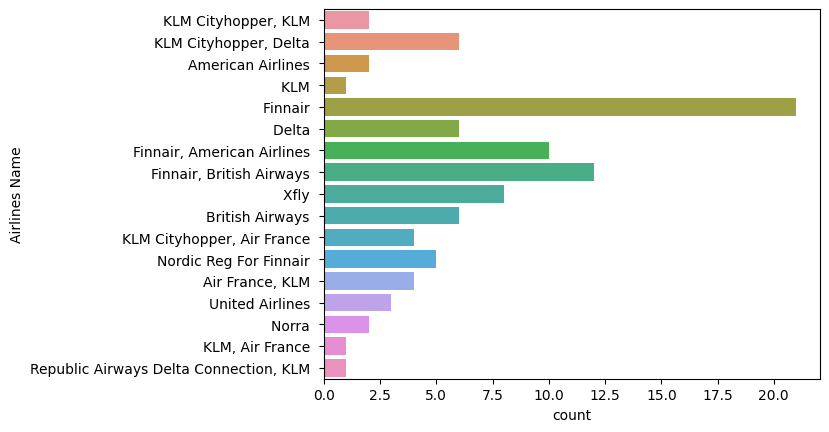

In [47]:
sns.countplot(y = 'Airlines Name', data = df)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, 'Air France, KLM '),
  Text(1, 0, 'American Airlines '),
  Text(2, 0, 'British Airways '),
  Text(3, 0, 'Delta '),
  Text(4, 0, 'Finnair '),
  Text(5, 0, 'Finnair, American Airlines '),
  Text(6, 0, 'Finnair, British Airways '),
  Text(7, 0, 'KLM '),
  Text(8, 0, 'KLM Cityhopper, Air France '),
  Text(9, 0, 'KLM Cityhopper, Delta '),
  Text(10, 0, 'KLM Cityhopper, KLM '),
  Text(11, 0, 'KLM, Air France '),
  Text(12, 0, 'Nordic Reg For Finnair '),
  Text(13, 0, 'Norra '),
  Text(14, 0, 'Republic Airways Delta Connection, KLM '),
  Text(15, 0, 'United Airlines '),
  Text(16, 0, 'Xfly ')])

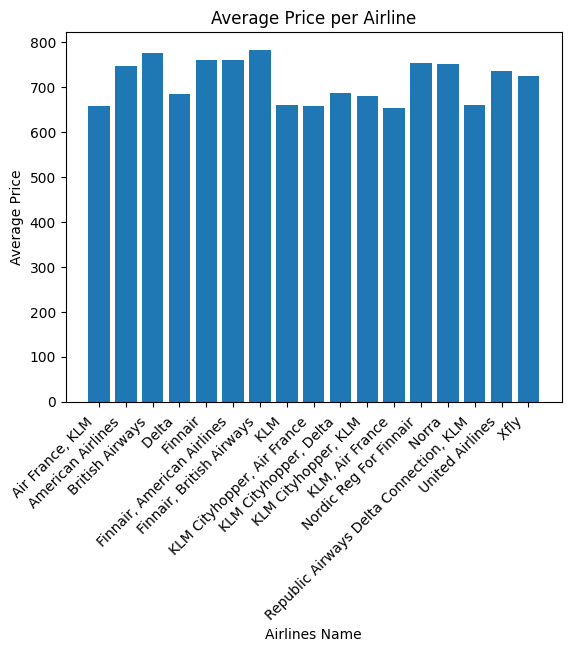

In [48]:
average_prices = df.groupby('Airlines Name')['Price'].mean().reset_index()
plt.bar(average_prices['Airlines Name'], average_prices['Price'])
plt.xlabel('Airlines Name')
plt.ylabel('Average Price')
plt.title('Average Price per Airline')
plt.xticks(rotation=45, ha='right')

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Amsterdam Schiphol'),
  Text(1, 0, 'London Heathrow'),
  Text(2, 0, 'Stockholm Arlanda'),
  Text(3, 0, 'Paris Charles de Gaulle'),
  Text(4, 0, 'Reykjavik Keflavik Intl'),
  Text(5, 0, 'Frankfurt am Main')])

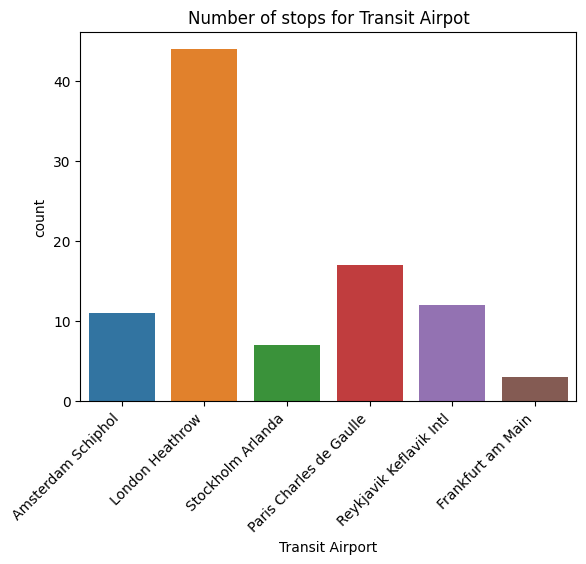

In [49]:
plt.title('Number of stops for Transit Airpot')
sns.countplot(x = 'Transit Airport', data = df)
plt.xticks(rotation=45, ha='right')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'Delta'),
  Text(1, 0, 'KLM'),
  Text(2, 0, 'Priceline'),
  Text(3, 0, 'American Airlines'),
  Text(4, 0, 'British Airways'),
  Text(5, 0, 'eDreams'),
  Text(6, 0, 'Gurufare'),
  Text(7, 0, 'mytrip.com'),
  Text(8, 0, 'Kiwi.com'),
  Text(9, 0, 'oojo'),
  Text(10, 0, 'OneTravel'),
  Text(11, 0, 'Iberia'),
  Text(12, 0, 'Finnair')])

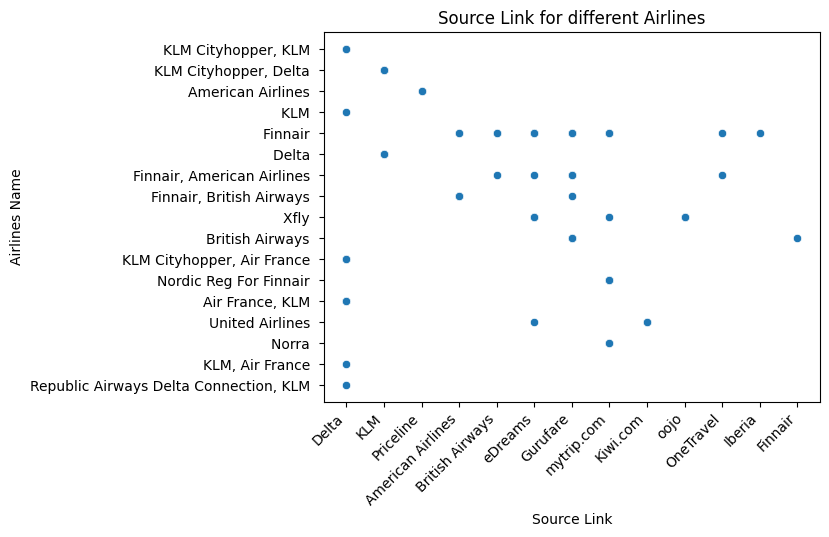

In [50]:
# Countplot for churn and voice mail plan

plt.title('Source Link for different Airlines')
sns.scatterplot(x = 'Source Link', y = 'Airlines Name', data = df)
plt.xticks(rotation=45, ha='right')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'Delta'),
  Text(1, 0, 'KLM'),
  Text(2, 0, 'Priceline'),
  Text(3, 0, 'American Airlines'),
  Text(4, 0, 'British Airways'),
  Text(5, 0, 'eDreams'),
  Text(6, 0, 'Gurufare'),
  Text(7, 0, 'mytrip.com'),
  Text(8, 0, 'Kiwi.com'),
  Text(9, 0, 'oojo'),
  Text(10, 0, 'OneTravel'),
  Text(11, 0, 'Iberia'),
  Text(12, 0, 'Finnair')])

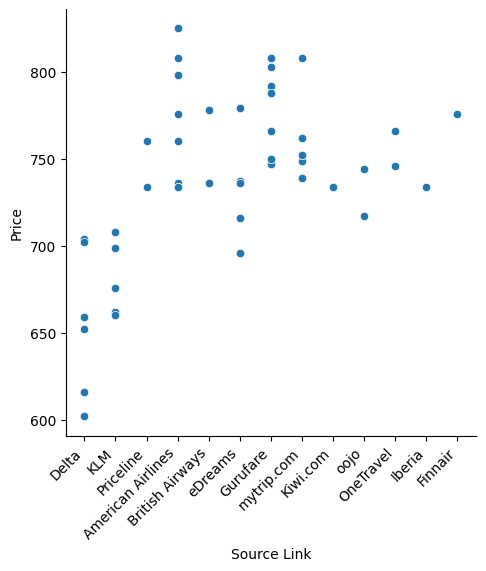

In [51]:
sns.relplot(x = 'Source Link', y = 'Price', data = df)
plt.xticks(rotation=45, ha='right')


In [62]:
pricing= df['Price']
print(pricing)

306    659
307    662
309    734
310    659
311    760
      ... 
421    825
422    659
424    766
425    702
428    803
Name: Price, Length: 94, dtype: int64


In [66]:
flights = df
print(flights)

                               Airlines Name Departure Time Arrival Time  \
306                     KLM Cityhopper, KLM           1:55         7:25    
307                   KLM Cityhopper, Delta           1:55         7:25    
309                       American Airlines           2:00         8:10    
310                                     KLM           1:55         7:25    
311                       American Airlines           7:50         1:45    
..                                       ...            ...          ...   
421                Finnair, British Airways           7:50         1:45    
422  Republic Airways Delta Connection, KLM           1:55         7:25    
424                                 Finnair           7:50         5:20    
425                     KLM Cityhopper, KLM           7:00         3:50    
428                Finnair, British Airways           4:00        10:10    

    Departure Location Arrival Destination Flight Duration  Direct FLight  \
306       

In [74]:
#User Interaction
import csv

class Flight:
    def _init_(self, airline, price, duration, stops, layover_duration, aircraft_type):
        self.airline = airline
        self.price = price
        self.duration = duration
        self.stops = stops
        self.layover_duration = layover_duration
        self.aircraft_type = aircraft_type



# reading data from csv file
def read_flights_from_csv(file_path):
    flights = []
    with open(file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
           # Remove commas from the 'Price' field and convert it to float
            price = row['Price']
            # Convert 'Flight Duration' to minutes
            flight_duration = row['Flight Duration']
            # Store 'Transit Location' as a string
            transit_location = row['Transit Location']
            # Convert 'Layover Duration' to minutes
            layover_duration = row['Layover Time']
            aircraft_type = row['Airlines Name']
            flight = Flight(row['Airlines Name'], price, flight_duration, transit_location, layover_duration, aircraft_type)
            flights.append(flight)
    return flights

# filtering the data according to the preferences given by user
def filter_flights(user_preferences, flights):
    filtered_flights = []
    for flight in flights:

        try:
            if isinstance(flight.price, int):
                print(flight.duration, int(user_preferences["duration_min"]) <= flight.duration <= int(user_preferences["duration_max"]))
                if (int(user_preferences["price_min"]) <= flight.price <= int(user_preferences["price_max"]) and
                    user_preferences["duration_min"] <= flight.duration <= user_preferences["duration_max"]):
                    filtered_flights.append(flight)
        except AttributeError:
            # Handle the case where 'price' attribute is missing or not an integer
            pass
    return filtered_flights

1
# Asking user input for flight preferences
user_preferences = {
    "price_min": int(input("Enter minimum price: ")),
    "price_max": int(input("Enter maximum price: ")),
    "duration_min": float(input("Enter minimum duration : ")),
    "duration_max": float(input("Enter maximum duration : ")),
    "direct_flight": input("Direct flight only? (yes/no): ").lower() == "yes",
    "layover_max": float(input("Enter maximum layover duration: ")),
    "airlines": input("Enter preferred airlines (comma-separated): ").split(",")
}

# Read flights from CSV file
flights = df
#flights = read_flights_from_csv('flight.csv')



# Filtering flights based on user preferences
filtered_flights = filter_flights(user_preferences, flights)

# User input for sorting criteria
sorting_criteria = input("Enter sorting criteria (price/duration/stops): ")

# Validate user input
valid_criteria = ["price", "duration", "stops"]
if sorting_criteria not in valid_criteria:
    print("Invalid sorting criteria. Sorting by price by default.")
    sorting_criteria = "price"

# Sorting flights based on user criteria
sorted_flights = sorted(filtered_flights, key=lambda x: getattr(x, sorting_criteria))

# Displaying the sorted list of flights with durations in hours and minutes format
for flight in sorted_flights:
    #duration_hours = flight.duration // 60
    #duration_minutes = flight.duration % 60

    # Handle None values in layover_duration
    #layover_hours = flight.layover_duration // 60 if flight.layover_duration is not None else 0
    #layover_minutes = flight.layover_duration % 60 if flight.layover_duration is not None else 0


    print("Airline: {}, Price: ${}, Duration: {} hours {} minutes, Stops: {}, Layover Duration: {} hours {} minutes, Aircraft Type: {}".format(
        flight.airline, flight.price, duration_hours, duration_minutes, flight.stops, layover_hours, layover_minutes, flight.aircraft_type))

Enter minimum price: 100
Enter maximum price: 900
Enter minimum duration : 2
Enter maximum duration : 10
Direct flight only? (yes/no): yes
Enter maximum layover duration: 3
Enter preferred airlines (comma-separated): Finnair
Enter sorting criteria (price/duration/stops): price
